# Build the news sentiments dataset

In [1]:
try:
    import alpha_vantage
except:
    ! pip install alpha_vantage
    import alpha_vantage

import requests
from pprint import pprint
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import json
import time
from tqdm import tqdm
import calendar
import os
import random
sns.set()
pd.set_option('display.max_colwidth',1000)

In [2]:
import logging
# set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# create a file handler
handler = logging.FileHandler('news_sentiment_dataset.log')
handler.setLevel(logging.INFO)
# create a logging format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(handler)

Load all keys for the alpha vantage api and multiply it by 5 since each key is allowed up to 5 requests per minute

In [3]:
with open('../keys.json') as f:
    keys = json.load(f) * 5

In [4]:
import string 

def get_sentiments(company_symbol='', news_topic='', time_from='', time_to='', sort_by='RELEVANCE'):
    endpoint = "https://www.alphavantage.co/query"
    parameters = {
        "function": "NEWS_SENTIMENT",
        "sort": sort_by,
        "limit": "200"
    }
    if time_from and time_to: parameters['time_from'] = time_from; parameters['time_to'] = time_to
    if news_topic: parameters['topics'] = news_topic
    if company_symbol: parameters['tickers'] = company_symbol
    for i in range(100):
        parameters['apikey'] = ''.join(random.choices(string.ascii_uppercase + string.digits, k=15))
        # Send a GET request to the API endpoint
        response = requests.get(endpoint, params=parameters)
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            if 'Note' not in data: 
                break
            logger.warning(f'API key {parameters["apikey"]} has been used too many times. response note: {data["Note"]}')
            data = None
            time.sleep(1)
        else: 
            logger.error(f'API key {parameters["apikey"]} has returned an error. response note: {response.json()}')
            return
    return data

# pprint(get_sentiments())

### Download all news sentiments from the past 100 days
Create a dataframe of the sentiments grouped by ticker symbols and sorted by time

Note that the sentiment score values indicate:
* Bearish: x <= -0.35
* Somewhat-Bearish: -0.35 < x <= -0.15
* Neutral: -0.15 < x < 0.15
* Somewhat_Bullish: 0.15 <= x < 0.35 
* Bullish: x >= 0.35


Note that another value maintained is the relevance score indicating the relevance of each article to the ticker 0 < x <= 1, with a higher score indicating higher relevance. However, this value is ignored for now. 

In [5]:
def sweep_news_in_range(start_time: datetime, day_range: int = 100):
    # create a folder to store the sentiments and ignore if it already exists
    os.makedirs('sentiments', exist_ok=True)
    sentiment_list = []
    for i in tqdm(range(day_range)):
        # repeat the process for ealiest and latest
        for sort_by in ['LATEST', 'EARLIEST', 'RELEVANCE']:
            # get the time range
            time_to = (start_time - timedelta(days=i)).strftime('%Y%m%dT%H%M')
            time_from = (start_time - timedelta(days=i+1)).strftime('%Y%m%dT%H%M')
            # get the news sentiment for the past week
            sentiment = get_sentiments(news_topic='financial_markets', time_from=time_from, time_to=time_to, sort_by=sort_by)
            if sentiment is None:
                logger.error(f'Unnable to fetch sentiment data for {sort_by} from {time_from} to {time_to}')
                continue
            with open(os.path.join('sentiments', f'sentiments_{sort_by}_{time_from}.json'), 'w') as f:
                json.dump(sentiment, f, indent=4)
            # append the sentiment to the list
            sentiment_list.append(sentiment)
    return sentiment_list

### Load the existing sentiment dataset and only sweep over unseen articles

In [6]:
try: 
    sent_df = pd.read_csv('sentiments.csv').drop(columns=['Unnamed: 0'], errors='ignore')
    # get the timedelta between the last date in the csv and the current date
    day_range = (datetime.now() - pd.to_datetime(sent_df['time']).iloc[0]).days + 1
except FileNotFoundError: 
    sent_df = pd.DataFrame()
    day_range = 100

start_time = datetime.now()
# # get a the datetime 47 days ago
# start_time = datetime.now() - timedelta(days=47)
# day_range = 365-47

# start sweeping from right now, for older sweeps change datetime to datetime.now() - timedelta(days=num_days_past)
all_news = sweep_news_in_range(start_time, day_range)

100%|██████████| 4/4 [01:54<00:00, 28.74s/it]


Parse out all necessary data from the raw jsons to create an ordered csv dataset

In [7]:
ordered_sentiments = []
# get a list of all files in the sentiments folder
for news_file in tqdm(os.listdir('sentiments')):
    with open(os.path.join('sentiments', news_file)) as f:
        news = json.load(f)
    for article in news['feed']:
        # parse date time from YYYYMMDDTHHMM format to datetime object
        time_pub = datetime.strptime(article['time_published'], '%Y%m%dT%H%M%S')
        # append overall article sentiment to the list
        ordered_sentiments.append({'ticker': None, 'sentiment': article['overall_sentiment_score'], 'time': time_pub, 'url': article['url']})
        # append each ticker mentioned in the article to the sentiment list
        for tickers_sents in article['ticker_sentiment']:
            ordered_sentiments.append({'ticker': tickers_sents['ticker'], 'sentiment': tickers_sents['ticker_sentiment_score'], 'time': time_pub, 'url': article['url']})

# new_df = pd.DataFrame(ordered_sentiments).sort_values(by='time', ascending=False)
new_df = pd.DataFrame(ordered_sentiments)
# parse out anything between https:// and / in the url or http:// and / in the url
new_df['site'] = new_df['url'].apply(lambda x: x.split('https://')[1].split('/')[0] if 'https' in x else x.split('http://')[1].split('/')[0])
# create a dataframe from the list of dictionaries and add it to the existing dataframe
new_sent_df = pd.concat([new_df, sent_df], axis=0, ignore_index=True)

100%|██████████| 339/339 [00:02<00:00, 115.29it/s]


Tweak variables to be the same type before saving

In [8]:
new_sent_df['sentiment'] = new_sent_df['sentiment'].astype(float)
new_sent_df['time'] = pd.to_datetime(new_sent_df['time'])
new_sent_df = new_sent_df.drop_duplicates(ignore_index=True).sort_values(by='time', ascending=False)
# TODO maybe drop the url column if the data set size gets too big
# sent_df.drop(columns=['url'], inplace=True)
# save the dataframe to a csv file
new_sent_df.to_csv(f'sentiments.csv', index=False)
new_sent_df

,ticker,sentiment,time,url,site
138262,None,0.182450,2023-02-12 11:26:00,https://www.fool.com/investing/2023/02/12/3-ultra-high-yield-dividend-stocks-that-are-safe-t/,www.fool.com
138266,EPR,0.193352,2023-02-12 11:26:00,https://www.fool.com/investing/2023/02/12/3-ultra-high-yield-dividend-stocks-that-are-safe-t/,www.fool.com
138265,KRC,0.116319,2023-02-12 11:26:00,https://www.fool.com/investing/2023/02/12/3-ultra-high-yield-dividend-stocks-that-are-safe-t/,www.fool.com
138264,FDS,0.103881,2023-02-12 11:26:00,https://www.fool.com/investing/2023/02/12/3-ultra-high-yield-dividend-stocks-that-are-safe-t/,www.fool.com
138263,SPG,0.128274,2023-02-12 11:26:00,https://www.fool.com/investing/2023/02/12/3-ultra-high-yield-dividend-stocks-that-are-safe-t/,www.fool.com
...,...,...,...,...,...
111,FTNT,0.306949,2022-10-30 11:10:00,https://www.fool.com/investing/2022/10/30/2-cybersecurity-stocks-that-could-help-set-you-up/,www.fool.com
110,None,0.322371,2022-10-30 11:10:00,https://www.fool.com/investing/2022/10/30/2-cybersecurity-stocks-that-could-help-set-you-up/,www.fool.com
40,None,0.216010,2022-10-30 11:07:00,https://www.fool.com/investing/2022/10/30/general-motors-making-money-again-gm-stock/,www.fool.com
41,GM,0.387429,2022-10-30 11:07:00,https://www.fool.com/investing/2022/10/30/general-motors-making-money-again-gm-stock/,www.fool.com


In [9]:
"""temp code, merge the old dataset with the new one"""
# old_df = pd.read_csv('sentiments_old.csv').set_index('ticker')
# old_df['time'] = pd.to_datetime(old_df['time'])
# old_df['site'] = old_df['url'].apply(lambda x: x.split('https://')[1].split('/')[0] if 'https' in x else x.split('http://')[1].split('/')[0])
# new_df = pd.concat([old_df, sent_df], axis=0).drop_duplicates().sort_values(by='time', ascending=False)
# new_df['time'] = pd.to_datetime(new_df['time'])
# # save the dataframe to a csv file
# new_df.to_csv(f'sentiments.csv')

'temp code, merge the old dataset with the new one'

In [10]:
sent_df = pd.read_csv('sentiments.csv')
# parse out anything between https:// and / in the url or http:// and / in the url. if there is no url column, ignore the error
if 'url' in sent_df.columns:
    sent_df['site'] = sent_df['url'].apply(lambda x: x.split('https://')[1].split('/')[0] if 'https' in x else x.split('http://')[1].split('/')[0])
sent_df = sent_df.drop(columns=['url'], errors='ignore').drop_duplicates().sort_values(by='time', ascending=False)
print(sent_df.head(5))
# use pandas describe to show statistics of the string columns
sent_df.describe(include=['object'])

  ticker  sentiment                 time          site
0    NaN   0.182450  2023-02-12 11:26:00  www.fool.com
3    FDS   0.103881  2023-02-12 11:26:00  www.fool.com
4    SPG   0.128274  2023-02-12 11:26:00  www.fool.com
1    EPR   0.193352  2023-02-12 11:26:00  www.fool.com
2    KRC   0.116319  2023-02-12 11:26:00  www.fool.com


,ticker,time,site
count,97036,137683,137683
unique,6322,25181,56
top,FOREX:USD,2023-01-06 13:00:00,www.benzinga.com
freq,1824,122,21649


Show the distribution of news sites in the dataset

# <span style="color:red">TODO Later on create a weighted histogram based on how right each site was</span>

Text(0.5, 1.0, 'Number of articles per site')

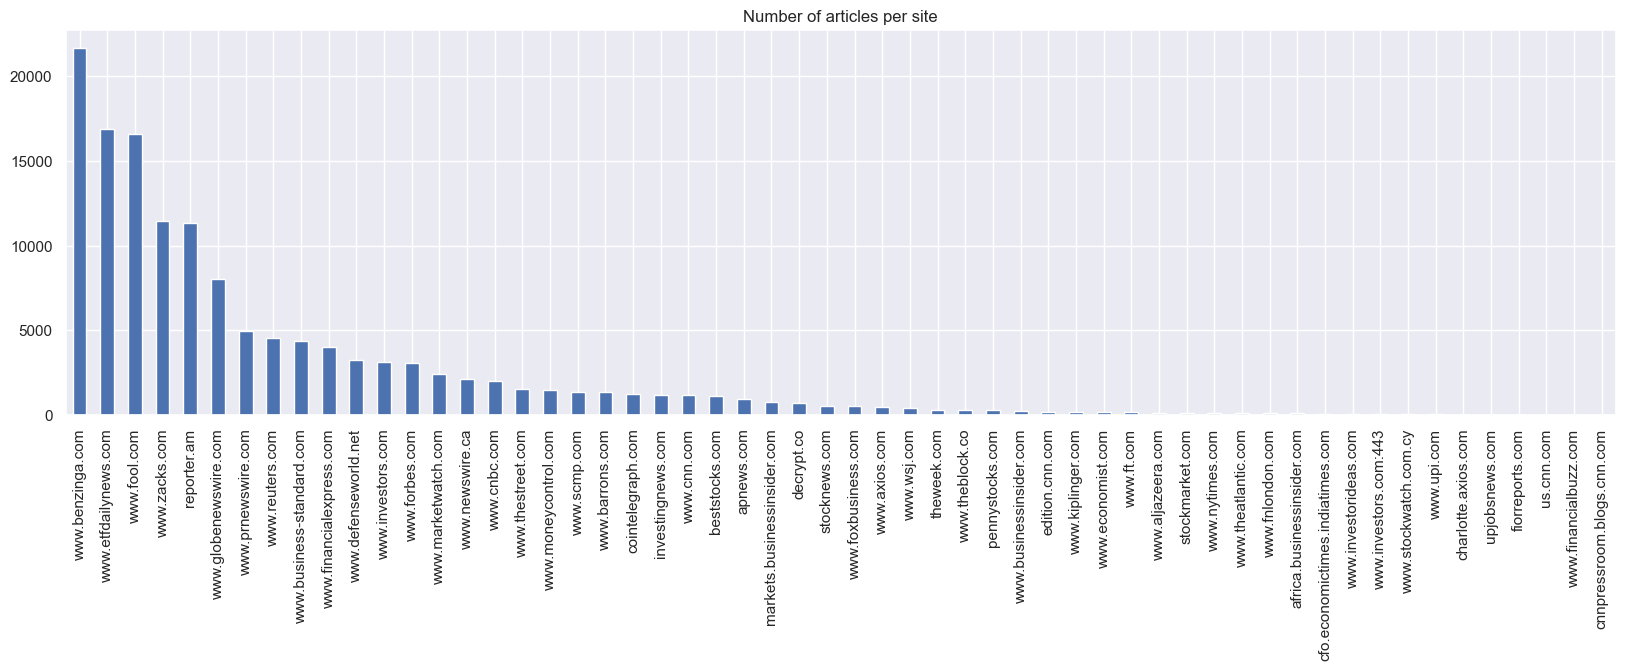

In [11]:
# create a histogram of the site column
sent_df['site'].value_counts().plot(kind='bar', figsize=(20,5))
plt.title('Number of articles per site')

### Add a histogram of the number of times each stock is mentioned

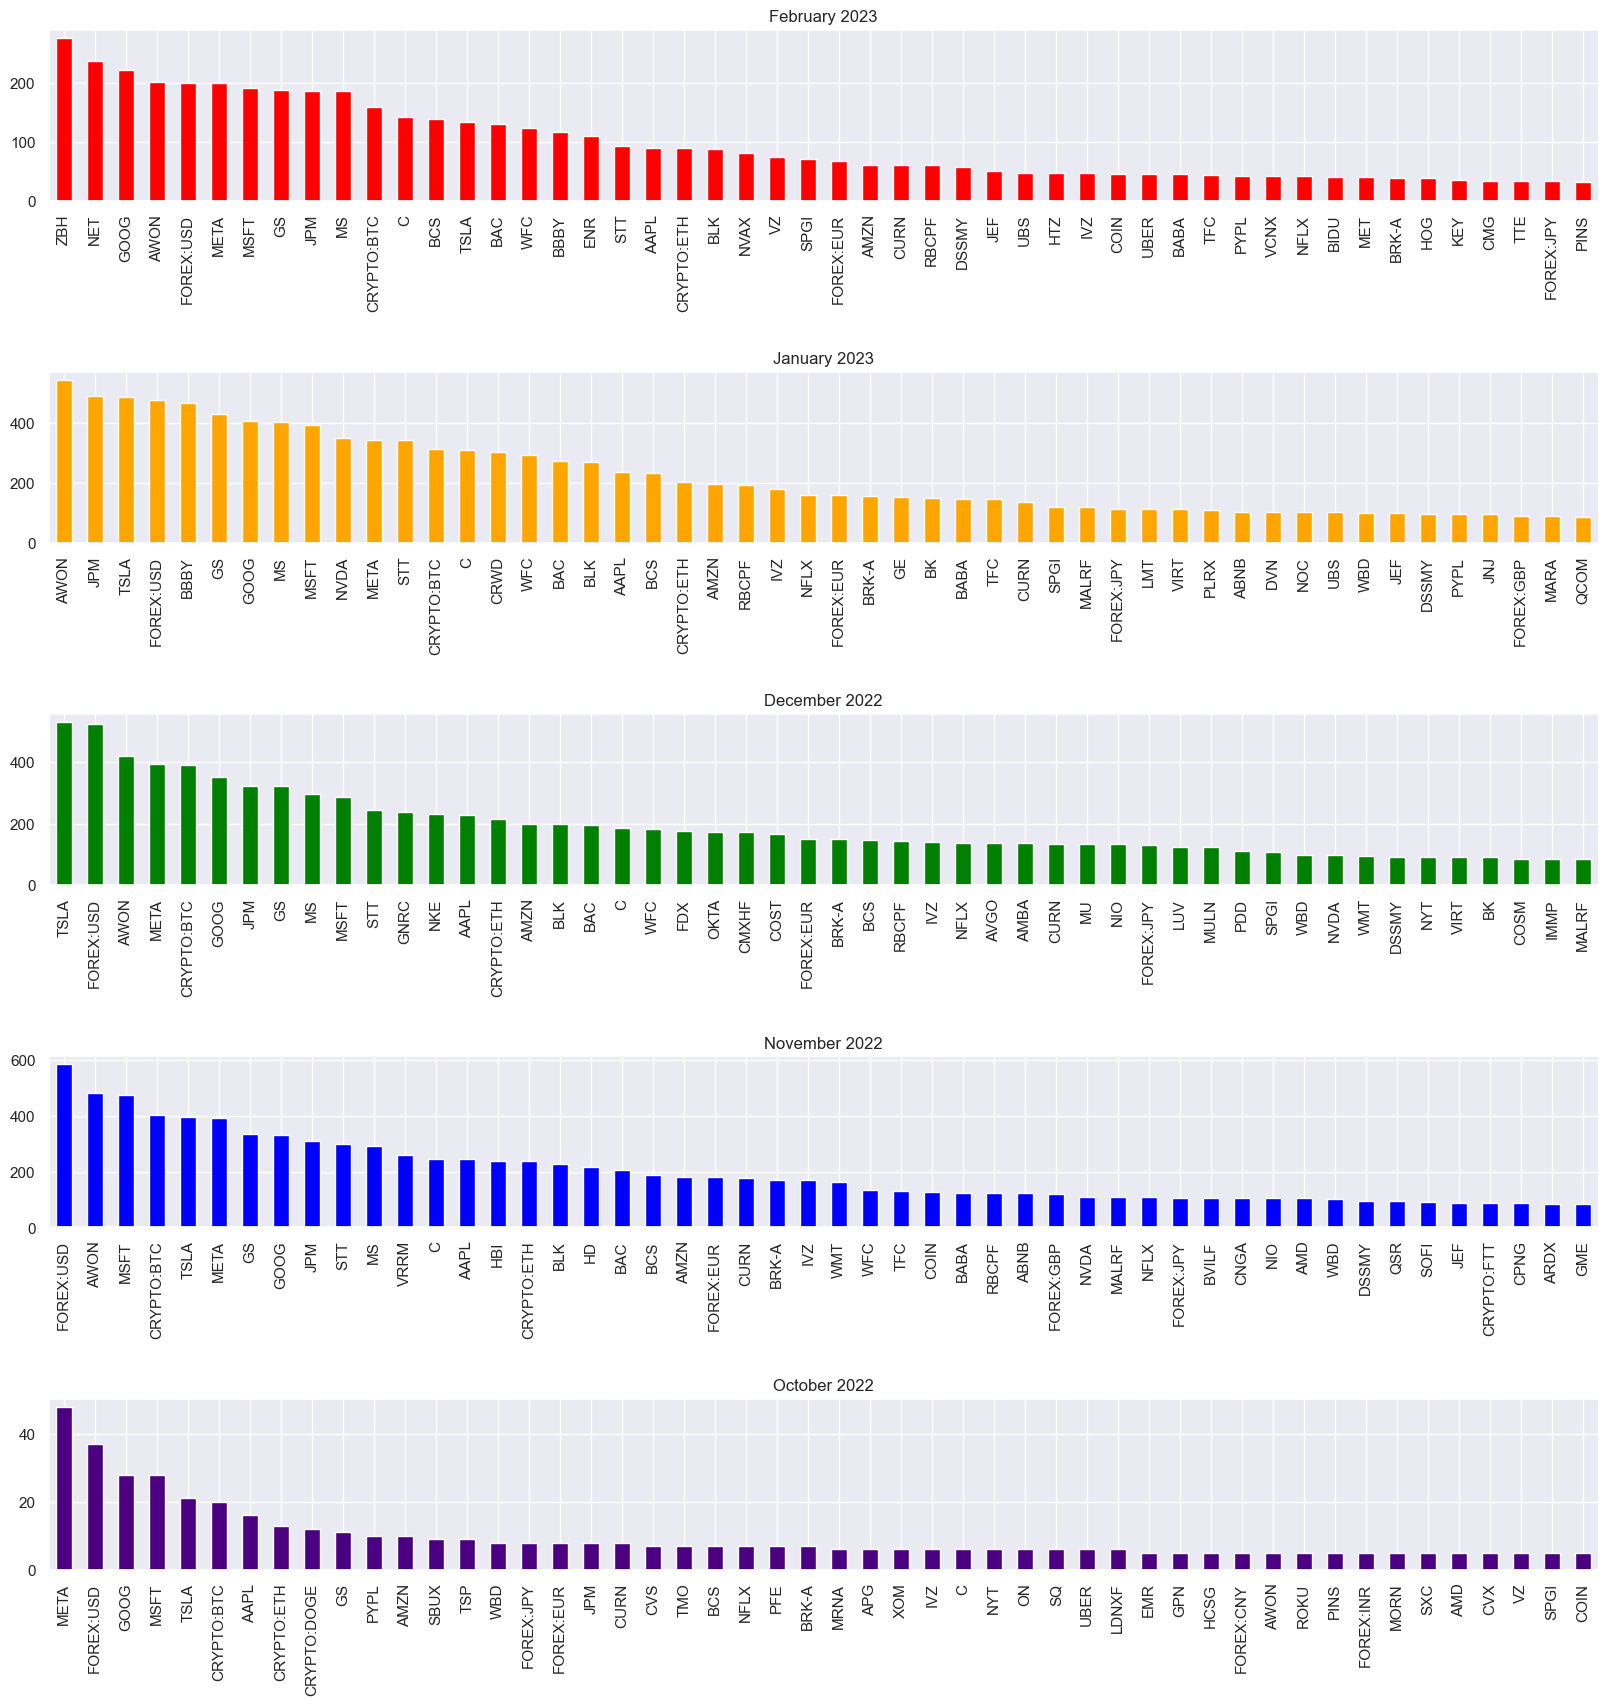

In [12]:
# plot a histogram of the number of times each ticker appears in the dataframe when grouped by month
# split the dataframe according to number of months before current month
sent_df['time'] = pd.to_datetime(sent_df['time']).dt.date
sent_df['month'] = pd.to_datetime(sent_df['time']).dt.month
sent_df['year'] = pd.to_datetime(sent_df['time']).dt.year
fig, axs = plt.subplots(len(sent_df['month'].unique()), figsize=(20, 20))
# create a list of 12 colors to use for the 12 months
colors = ['red', 'orange', 'green', 'blue', 'indigo', 'violet', 'brown', 'pink', 'gray', 'black', 'white', 'yellow']
plt.subplots_adjust(hspace=1)
for i, month in enumerate(sent_df['month'].unique()):
    # plot the top 50 tickers for each month
    sent_df[sent_df['month'] == month]['ticker'].value_counts().head(50).plot(kind='bar', ax=axs[i], label=month, color=colors[i])
    # convert month from number to name, by using 
    axs[i].set_title(calendar.month_name[month] + ' ' + str(sent_df[sent_df['month'] == month]['year'].unique()[0]))
# remove the month column when youre done
sent_df.drop(columns=['month', 'year'], inplace=True)
# save the figure
plt.savefig('stock_mentions_by_month.png')

## Basic analysis
Take MDNDF stock (mcdonalds japan).

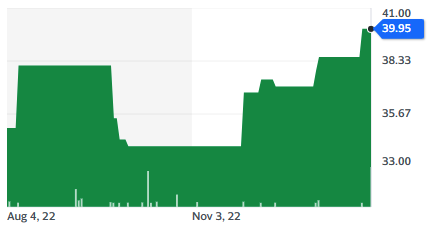

In [13]:
# load a png image
from PIL import Image
Image.open('Screenshot 2023-02-05 211157.png')

This stock crashed in late September by 20% and almost returned to its original price by December. It was highly mentioned in late October, so wed like to see whether the positive sentiments kept on flowing in November

In [14]:
endpoint = "https://www.alphavantage.co/query"
parameters = {
    "function": "TIME_SERIES_DAILY_ADJUSTED",
    "symbol": 'MDNDF',
    "outputsize": 'compact',
    "apikey": random.choice(keys),
}
# Send a GET request to the API endpoint
response = requests.get(endpoint, params=parameters)
# create a dataframe of the closing prices of each day
md_price = pd.DataFrame.from_dict(response.json()['Time Series (Daily)'], orient='index').sort_index().astype(float).reset_index().rename(columns={'index': 'time', '5. adjusted close': 'close'})
md_price['time'] = pd.to_datetime(md_price['time'])
md_price

,time,1. open,2. high,3. low,4. close,close,6. volume,7. dividend amount,8. split coefficient
0,2022-09-20,38.11,38.11,38.11,38.11,37.813994,50.0,0.0,1.0
1,2022-09-21,38.11,38.11,38.11,38.11,37.813994,0.0,0.0,1.0
2,2022-09-22,38.11,38.11,38.11,38.11,37.813994,0.0,0.0,1.0
3,2022-09-23,38.11,38.11,38.11,38.11,37.813994,0.0,0.0,1.0
4,2022-09-26,38.11,38.11,38.11,38.11,37.813994,450.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
95,2023-02-06,39.95,39.95,39.64,39.64,39.640000,287.0,0.0,1.0
96,2023-02-07,39.64,39.64,39.64,39.64,39.640000,0.0,0.0,1.0
97,2023-02-08,39.64,39.64,39.64,39.64,39.640000,0.0,0.0,1.0
98,2023-02-09,39.64,39.64,39.64,39.64,39.640000,0.0,0.0,1.0


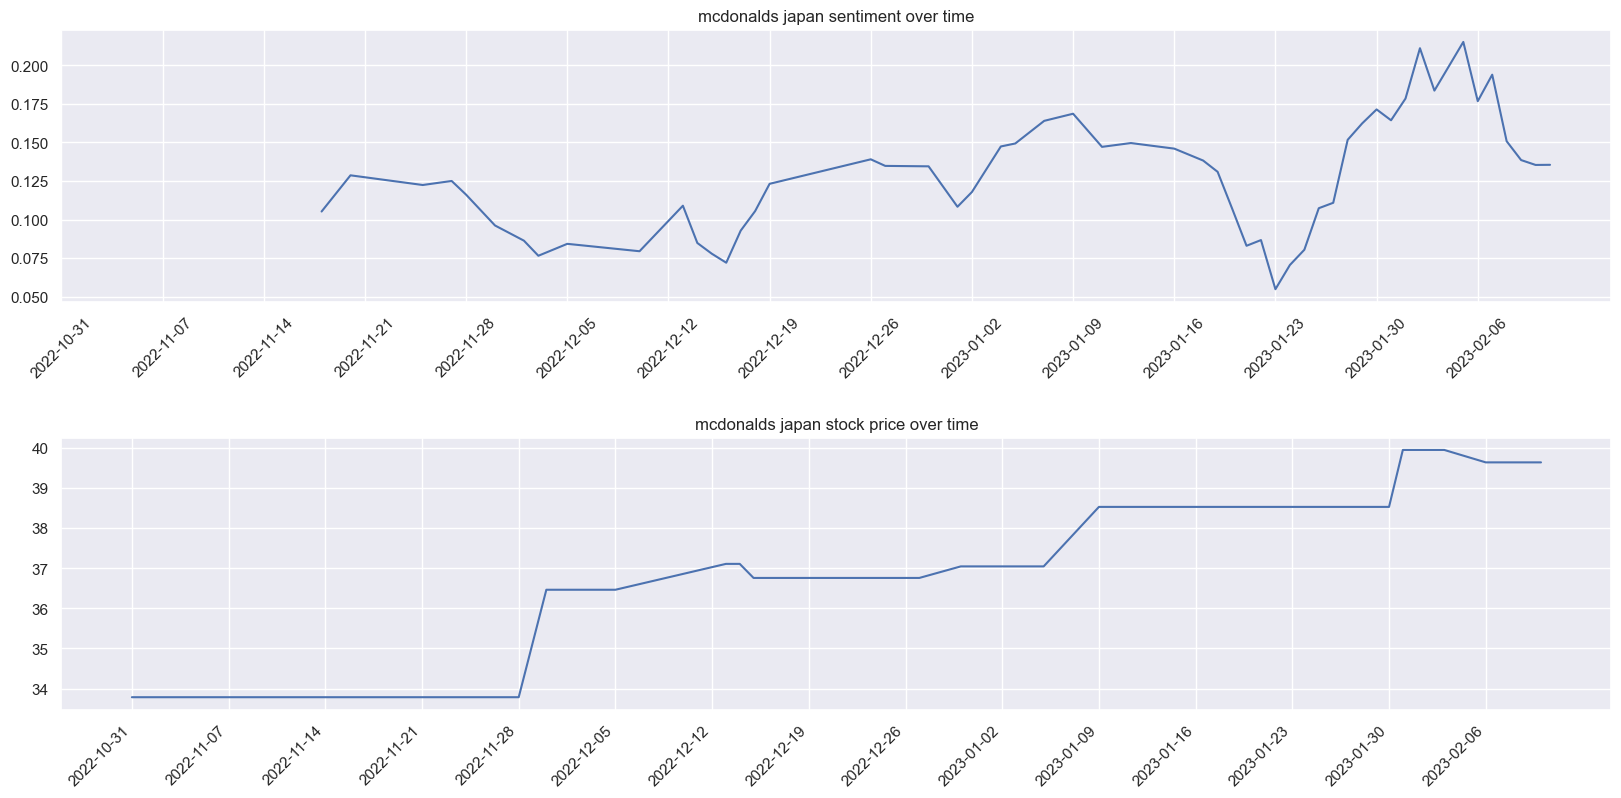

<Figure size 640x480 with 0 Axes>

In [15]:
# create two subplots, one for the sentiment and one for the price
fig, axs = plt.subplots(2, figsize=(20, 10))
# add horizontal space between the two subplots
plt.subplots_adjust(hspace=0.5)
# plot the average sentiment over the entire day and perform a rolling average over every 10 days
md_sent = sent_df[sent_df['ticker'] == 'MDNDF'].groupby('time')['sentiment'].mean().rolling(10).mean()
md_sent.plot(ax=axs[0], label='average sentiment')
axs[0].set_xlabel('')
axs[0].set_xticks(pd.date_range(md_sent.index.min(), md_sent.index.max(), freq='7D'), rotation=45)
axs[0].set_title('mcdonalds japan sentiment over time')

# build a series from stock price containing only rows with the same dates as the sentiment dataframe
new_price = md_price[md_price['time'].isin(sent_df[sent_df['ticker'] == 'MDNDF']['time'].unique())].set_index('time')['close']
# plot the stock price over time
new_price.plot(ax=axs[1], label='stock price')
axs[1].set_xlabel('')
axs[1].set_xticks(pd.date_range(new_price.index.min(), new_price.index.max(), freq='7D'))
axs[1].set_title('mcdonalds japan stock price over time')
# rotate the xticks by 45 degrees for both subplots
for ax in axs:
    ax.tick_params(axis='x', rotation=45)

plt.show()
plt.savefig('mdndf_analysis.png')

As suspected, the news sentiments suggested to buy in november. Then, by the end of December suggested to sell, and in January suggested to buy again.

### <span style="color:green"> This means we could choose one of two approaches: </span>

1. Scan for any stocks that are being highly active in the news space, then see if they are at a monthly low and have a positive mean sentiment we can buy (or short if the opposite case)
2. Scan for any stocks that are traded in a suspiciously large volume, and check the overall mean sentiment suggested by the news sources (this will be proven in the daily stock data scraping)
